In [49]:
import pandas as pd
import numpy as np
import os

In [50]:
df = pd.read_csv('all_leagues_data.csv')

In [51]:
# create a variable called current day
current_day = pd.to_datetime('today').date()

# convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date']).dt.date

# create a new df filter out the rows where the date is greater than the current day
model_df = df[df['Date'] < current_day]

In [52]:
model_df['Attendance'] = model_df['Attendance'].fillna(0) # setting null values to 0 because the NaN are from Covid-19 games with no attendance

model_df['Attendance'] = model_df['Attendance'].astype(int)

In [53]:
# remove rows with NaN values
model_df = model_df.dropna()

In [54]:
model_df[['home_goals', 'away_goals']] = model_df['Score'].str.split('–', expand=True).astype(int)

# rename xG and xG.1 columns to home_xG and away_xG
model_df.rename(columns={'xG': 'home_xg', 'xG.1': 'away_xg'}, inplace=True)

In [55]:
def get_result(row):
    if row['home_goals'] > row['away_goals']:
        return 'Home Win'
    elif row['home_goals'] < row['away_goals']:
        return 'Away Win'
    else:
        return 'Draw'
    
model_df['Result'] = model_df.apply(get_result, axis=1)

In [56]:
model_df['Day'] = pd.to_datetime(model_df['Date']).dt.day_name()

model_df['Season'] = model_df['Season'].apply(lambda x: x.split('-')[1])

In [57]:
model_df.reset_index(drop=True, inplace=True)

In [58]:
for x in model_df.Home.unique():
    temp_df = model_df[(model_df['Home'] == x) | (model_df['Away'] == x)]
    temp_df = temp_df.sort_values(['Date'])

    temp_df['goal_value_to_calculate'] = temp_df.apply(lambda y: y['home_goals'] if y['Home'] == x else y['away_goals'], axis=1)
    temp_df['rolling_avg_goals'] = temp_df['goal_value_to_calculate'].rolling(window = 5, closed = 'left', min_periods = 1).mean()

    for index, row in temp_df.iterrows():
        if row['Home'] == x:
            model_df.at[index, 'home_rolling_avg_goals'] = row['rolling_avg_goals']
        else:
            model_df.at[index, 'away_rolling_avg_goals'] = row['rolling_avg_goals']

In [59]:
for x in model_df.Home.unique():
    temp_df = model_df[(model_df['Home'] == x) | (model_df['Away'] == x)]
    temp_df = temp_df.sort_values(['Date'])

    temp_df['xg_value_to_calculate'] = temp_df.apply(lambda y: y['home_xg'] if y['Home'] == x else y['away_xg'], axis=1)
    temp_df['rolling_avg_xG'] = temp_df['xg_value_to_calculate'].rolling(window = 5, closed = 'left', min_periods = 1).mean()

    for index, row in temp_df.iterrows():
        if row['Home'] == x:
            model_df.at[index, 'home_rolling_avg_xG'] = row['rolling_avg_xG']
        else:
            model_df.at[index, 'away_rolling_avg_xG'] = row['rolling_avg_xG']

In [60]:
model_df = model_df.dropna(subset=['home_rolling_avg_goals', 'away_rolling_avg_goals', 'home_rolling_avg_xG', 'away_rolling_avg_xG'])

In [61]:
# create a new column for the central moving average of the home goals
model_df['home_goals_cma'] = model_df['home_goals'].expanding().mean()
model_df['home_xg_cma'] = model_df['home_xg'].expanding().mean()

# away goals
model_df['away_goals_cma'] = model_df['away_goals'].expanding().mean()
model_df['away_xg_cma'] = model_df['away_xg'].expanding().mean()

# create a new column by dividing the home goals by central moving average
model_df['home_goals_div_cma'] = model_df['home_goals'] / model_df['home_goals_cma']
model_df['home_xg_div_cma'] = model_df['home_xg'] / model_df['home_xg_cma']

# away goals
model_df['away_goals_div_cma'] = model_df['away_goals'] / model_df['away_goals_cma']
model_df['away_xg_div_cma'] = model_df['away_xg'] / model_df['away_xg_cma']

In [62]:
# set Wk column to integer
model_df['Wk'] = model_df['Wk'].astype(int)

# create a new column called quarter. divide the season into 4 quarters using the Wk column and assign a value between 1 and 4
model_df['quarter'] = np.where(model_df['Wk'].astype(int) <= 9, 1,
                np.where(model_df['Wk'].astype(int) <= 18, 2,
                np.where(model_df['Wk'].astype(int) <= 27, 3, 4)))

# using home_goals_div_cma, take the mean of the column for each quarter. put into new column called home_goals_seasonality
model_df['home_goals_seasonality'] = model_df.groupby('quarter')['home_goals_div_cma'].transform('mean')
model_df['home_xg_seasonality'] = model_df.groupby('quarter')['home_xg_div_cma'].transform('mean')

# away goals
model_df['away_goals_seasonality'] = model_df.groupby('quarter')['away_goals_div_cma'].transform('mean')
model_df['away_xg_seasonality'] = model_df.groupby('quarter')['away_xg_div_cma'].transform('mean')

# create a new column called home_goals_deseasonalised by dividing home_goals by home_goals_seasonality
model_df['home_goals_deseasonalised'] = model_df['home_goals'] / model_df['home_goals_seasonality']
model_df['home_xg_deseasonalised'] = model_df['home_xg'] / model_df['home_xg_seasonality']

# away goals
model_df['away_goals_deseasonalised'] = model_df['away_goals'] / model_df['away_goals_seasonality']
model_df['away_xg_deseasonalised'] = model_df['away_xg'] / model_df['away_xg_seasonality']

In [63]:
model_df['Season'] = model_df['Season'].astype(int)
# set home goals and away goals to integer
model_df['home_goals'] = model_df['home_goals'].astype(int)
model_df['away_goals'] = model_df['away_goals'].astype(int)

In [64]:
# Ensure 'Result' is categorical or integer-based
model_df['Result'] = model_df['Result'].astype('category')  # or use int depending on your encoding

# Ensure 'home_goals' and 'away_goals' are integers
model_df['home_goals'] = pd.to_numeric(model_df['home_goals'], errors='coerce').fillna(0).astype(int)
model_df['away_goals'] = pd.to_numeric(model_df['away_goals'], errors='coerce').fillna(0).astype(int)

In [66]:
# import packages for random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

In [67]:
features = [column for column in model_df.drop(columns=[
    'Date', 'Day', 'Home', 'Away', 'Venue', 'Time', 'home_xg', 'away_xg', 'home_goals', 'Score', 'Referee', 'Attendance',
    'away_goals', 'Result', 'Season', 'quarter', 'home_goals_cma', 'home_xg_cma', 
    'away_goals_cma', 'away_xg_cma', 'home_goals_div_cma', 'home_xg_div_cma', 
    'away_goals_div_cma', 'away_xg_div_cma'])]

features

['Wk',
 'home_rolling_avg_goals',
 'away_rolling_avg_goals',
 'home_rolling_avg_xG',
 'away_rolling_avg_xG',
 'home_goals_seasonality',
 'home_xg_seasonality',
 'away_goals_seasonality',
 'away_xg_seasonality',
 'home_goals_deseasonalised',
 'home_xg_deseasonalised',
 'away_goals_deseasonalised',
 'away_xg_deseasonalised']

In [ ]:
from sklearn.model_selection import GridSearchCV

train_data = model_df[model_df['Season'] <= 2022]
test_data = model_df[model_df['Season'] == 2023]

X_train = train_data[features]
y_train = train_data['Result']

X_test = test_data[features]
y_test = test_data['Result']

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10 , 15, 20]
}
clf = RandomForestClassifier(random_state=69, max_depth=5, n_estimators=50)
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

grid_search.best_params_

{'max_depth': 15, 'n_estimators': 200}

In [75]:
clf = RandomForestClassifier(random_state=69, max_depth=15, n_estimators=200)
clf.fit(X_train, y_train)

predictions = clf.predict(X_test)

print(f'{round((accuracy_score(y_test, predictions)*100), 2)}% accuracy')

99.9% accuracy


In [70]:
prediction_data = model_df[model_df['Season'] == 2024]

X_test = prediction_data[features]
y_test = prediction_data['Result']

In [71]:
predictions = clf.predict(X_test)

print(f'{round((accuracy_score(y_test, predictions)*100), 2)}% accuracy')

99.71% accuracy


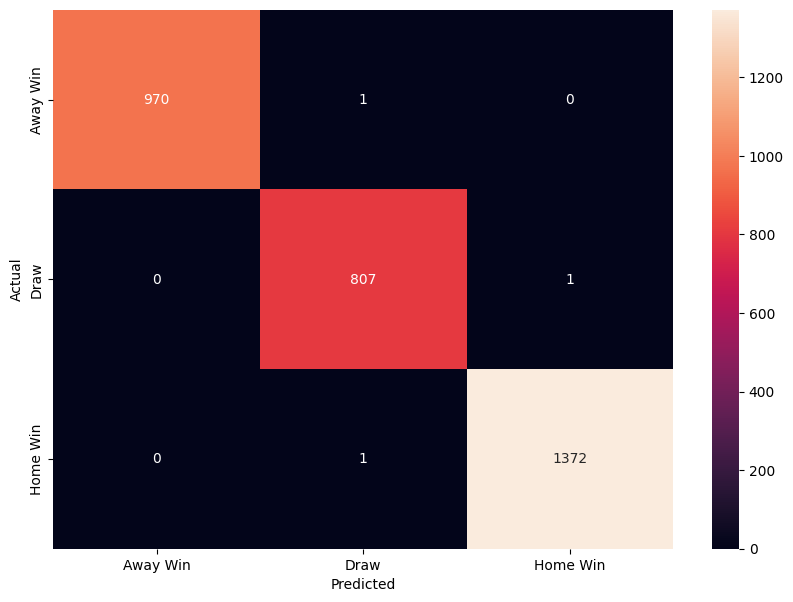

In [76]:
# confusion matrix

confusion_matrix(y_test, predictions)

# importing the packages for the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, predictions)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5, 1.5, 2.5], ['Away Win', 'Draw', 'Home Win'])
plt.yticks([0.5, 1.5, 2.5], ['Away Win', 'Draw', 'Home Win'])
plt.show()

In [77]:
model_df

,Wk,Day,Date,Time,Home,home_xg,Score,away_xg,Away,Attendance,...,away_xg_div_cma,quarter,home_goals_seasonality,home_xg_seasonality,away_goals_seasonality,away_xg_seasonality,home_goals_deseasonalised,home_xg_deseasonalised,away_goals_deseasonalised,away_xg_deseasonalised
10,2,Saturday,2017-08-19,12:30,Swansea City,0.4,0–4,3.0,Manchester Utd,20862,...,1.000000,1,0.999814,0.988250,1.033221,0.999764,0.000000,0.404756,3.871388,3.000709
11,2,Saturday,2017-08-19,15:00,Bournemouth,1.0,0–2,2.4,Watford,10501,...,0.888889,1,0.999814,0.988250,1.033221,0.999764,0.000000,1.011890,1.935694,2.400567
12,2,Saturday,2017-08-19,15:00,Southampton,2.1,3–2,2.0,West Ham,31424,...,0.810811,1,0.999814,0.988250,1.033221,0.999764,3.000558,2.124969,1.935694,2.000473
13,2,Saturday,2017-08-19,15:00,Leicester City,2.0,2–0,0.2,Brighton,31902,...,0.105263,1,0.999814,0.988250,1.033221,0.999764,2.000372,2.023780,0.000000,0.200047
14,2,Saturday,2017-08-19,15:00,Burnley,1.3,0–1,0.9,West Brom,19619,...,0.529412,1,0.999814,0.988250,1.033221,0.999764,0.000000,1.315457,0.967847,0.900213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29998,46,Saturday,2024-05-04,12:30,Swansea City,1.4,0–1,0.8,Millwall,17661,...,0.669834,4,1.013837,1.009997,1.018843,1.026282,0.000000,1.386142,0.981506,0.779513
29999,46,Saturday,2024-05-04,12:30,Ipswich Town,1.7,2–0,0.1,Huddersfield,29011,...,0.083732,4,1.013837,1.009997,1.018843,1.026282,1.972703,1.683173,0.000000,0.097439
30000,46,Saturday,2024-05-04,12:30,Sunderland,1.7,0–2,1.3,Sheffield Weds,41222,...,1.088511,4,1.013837,1.009997,1.018843,1.026282,0.000000,1.683173,1.963012,1.266708
30001,46,Saturday,2024-05-04,12:30,Rotherham Utd,3.1,5–2,1.3,Cardiff City,10547,...,1.088507,4,1.013837,1.009997,1.018843,1.026282,4.931758,3.069315,1.963012,1.266708


In [78]:
# save the model
import joblib

joblib.dump(clf, 'model_v2.pkl')

# save the features
joblib.dump(features, 'features_v2.pkl')

['features_v2.pkl']